In [1]:
# Sample of Final Dashboard Below
# All other cells are the Python code used to manipulate and clean the data

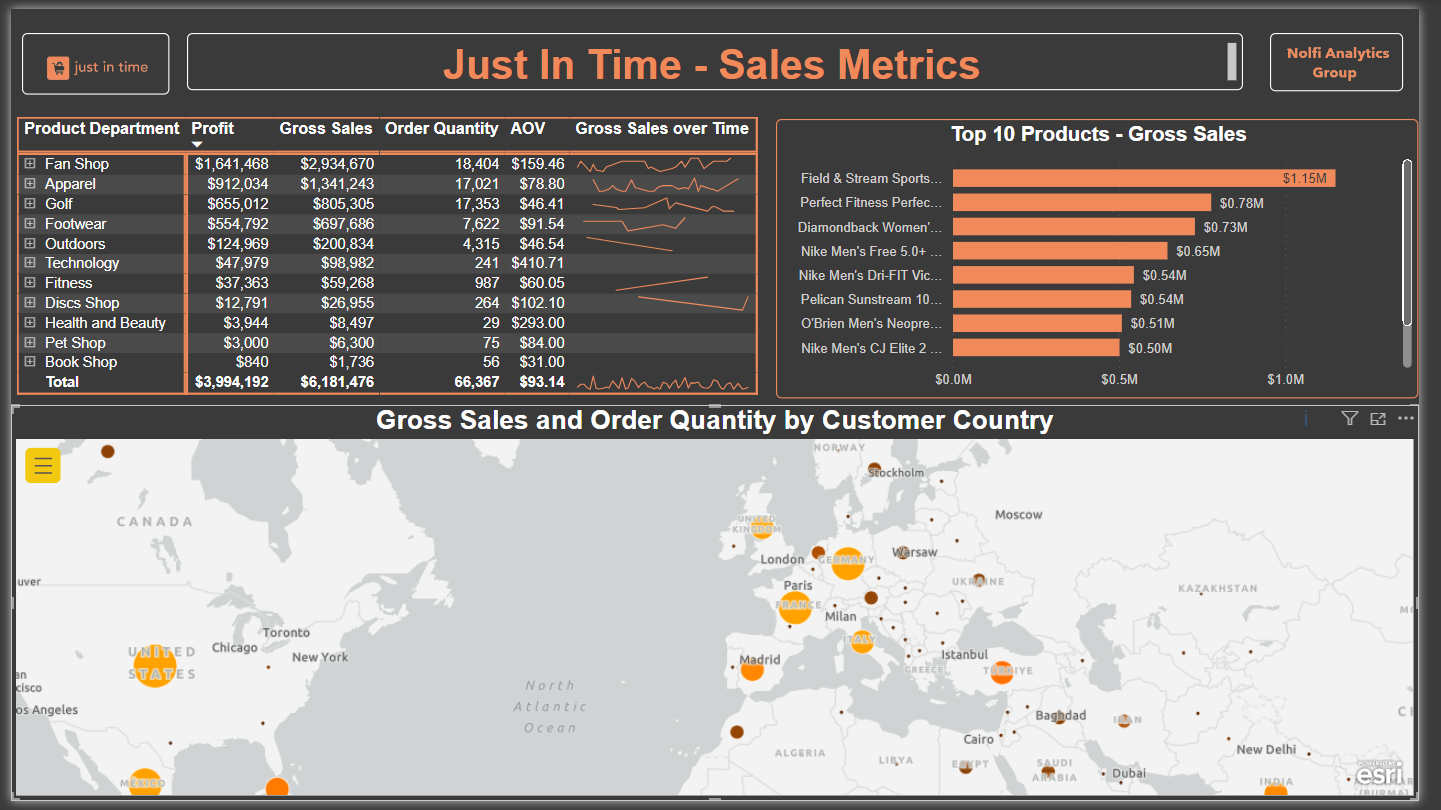

In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import sys
#!{sys.executable} -m pip install geopandas
#!{sys.executable} -m pip install geopy
import geopandas
import geopy
from geopy.geocoders import Nominatim
from geopy.distance import distance

In [2]:
# Import data
df_main=pd.read_csv("data/orders_and_shipments.csv")
df_main.head()

,Order ID,Order Item ID,Order YearMonth,Order Year,Order Month,Order Day,Order Time,Order Quantity,Product Department,Product Category,Product Name,Customer ID,Customer Market,Customer Region,Customer Country,Warehouse Country,Shipment Year,Shipment Month,Shipment Day,Shipment Mode,Shipment Days - Scheduled,Gross Sales,Discount %,Profit
0,3535,8793,201502,2015,2,21,14:07,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,7840,LATAM,Central America,Mexico,Puerto Rico,2015,2,27,Standard Class,4,400,0.25,200
1,4133,10320,201503,2015,3,2,07:37,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,1203,LATAM,South America,Brazil,Puerto Rico,2015,3,6,Standard Class,4,400,0.09,200
2,7396,18517,201504,2015,4,18,22:47,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,10866,LATAM,Central America,Mexico,Puerto Rico,2015,4,20,Standard Class,4,400,0.06,200
3,11026,27608,201506,2015,6,10,22:32,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,3576,Europe,Northern Europe,Denmark,Puerto Rico,2015,6,12,Standard Class,4,400,0.15,200
4,11026,27609,201506,2015,6,10,22:32,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,3576,Europe,Northern Europe,Denmark,Puerto Rico,2015,6,12,Standard Class,4,400,0.13,200


In [3]:
# Examine shape of df_main
df_main.shape

(30871, 24)

In [4]:
# Generate summary statistics for orders dataset
df_main.describe(include='all')

,Order ID,Order Item ID,Order YearMonth,Order Year,Order Month,Order Day,Order Time,Order Quantity,Product Department,Product Category,Product Name,Customer ID,Customer Market,Customer Region,Customer Country,Warehouse Country,Shipment Year,Shipment Month,Shipment Day,Shipment Mode,Shipment Days - Scheduled,Gross Sales,Discount %,Profit
count,30871.000000,30871.000000,30871.000000,30871.000000,30871.000000,30871.000000,30871,30871.000000,30871,30871,30871,30871.000000,30871,30871,30871,30871,30871.000000,30871.000000,30871.000000,30871,30871.000000,30871.000000,30871,30871.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,1440,NaN,11,49,113,NaN,5,23,139,2,NaN,NaN,NaN,4,NaN,NaN,18,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,08:27,NaN,Fan Shop,Cleats,Perfect Fitness Perfect Rip Deck,NaN,LATAM,Central America,USA,USA,NaN,NaN,NaN,Standard Class,NaN,NaN,0.02,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,42,NaN,11550,4298,4292,NaN,9118,5125,4392,18997,NaN,NaN,NaN,17994,NaN,NaN,1772,NaN
mean,35818.833792,89380.257361,201601.137411,2015.948657,6.271679,15.735026,NaN,2.149817,NaN,NaN,NaN,6477.672152,NaN,NaN,NaN,NaN,2015.955427,6.299569,15.978005,NaN,3.072495,200.235690,NaN,129.383305
std,20623.809444,51279.388574,79.438616,0.796323,3.373914,8.484049,NaN,1.461393,NaN,NaN,NaN,3932.830830,NaN,NaN,NaN,NaN,0.798863,3.360191,8.582789,NaN,1.184417,114.251482,NaN,52.649857
min,11.000000,29.000000,201501.000000,2015.000000,1.000000,1.000000,NaN,1.000000,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,2015.000000,1.000000,1.000000,NaN,1.000000,10.000000,NaN,6.000000
25%,17905.000000,44721.500000,201509.000000,2015.000000,3.000000,9.000000,NaN,1.000000,NaN,NaN,NaN,3177.000000,NaN,NaN,NaN,NaN,2015.000000,3.000000,9.000000,NaN,2.000000,120.000000,NaN,97.000000
50%,35886.000000,89624.000000,201606.000000,2016.000000,6.000000,16.000000,NaN,1.000000,NaN,NaN,NaN,6355.000000,NaN,NaN,NaN,NaN,2016.000000,6.000000,16.000000,NaN,4.000000,200.000000,NaN,125.000000
75%,53507.000000,133710.500000,201702.000000,2017.000000,9.000000,23.000000,NaN,3.000000,NaN,NaN,NaN,9577.000000,NaN,NaN,NaN,NaN,2017.000000,9.000000,23.000000,NaN,4.000000,300.000000,NaN,150.000000


In [5]:
# Check for missing values (remove head method to see all results), though no vals are missing
df_main.isnull().sum().head()

Order ID             0
 Order Item ID       0
 Order YearMonth     0
 Order Year          0
 Order Month         0
dtype: int64

In [6]:
# Some columns have a leading/trailing spaces in their names, let's remove those
df_main=df_main.rename(columns=lambda x: x.strip())
df_main.columns

Index(['Order ID', 'Order Item ID', 'Order YearMonth', 'Order Year',
       'Order Month', 'Order Day', 'Order Time', 'Order Quantity',
       'Product Department', 'Product Category', 'Product Name', 'Customer ID',
       'Customer Market', 'Customer Region', 'Customer Country',
       'Warehouse Country', 'Shipment Year', 'Shipment Month', 'Shipment Day',
       'Shipment Mode', 'Shipment Days - Scheduled', 'Gross Sales',
       'Discount %', 'Profit'],
      dtype='object')

In [7]:
# Replace dashes in discount percent column with 0s

# First, strip spaces from Discount % column
df_main['Discount %']=df_main['Discount %'].str.strip()

# Make replacements
df_main['Discount %']=np.where(df_main['Discount %']=="-", 0, df_main['Discount %'])

# Change dtype of Discount %
df_main=df_main.astype({'Discount %':'float'})

In [8]:
# For dashboard build, having a datetime value in df_main will be useful
# Concat order year, month, day, and time into a format that pd.to_datetime will accept
df_main['Order DT']=df_main['Order Year'].astype(str)+'-'+df_main['Order Month'].astype(str)+'-'+df_main['Order Day'].astype(str)+' '+df_main['Order Time'].astype(str)

# Convert new col to DT
df_main['Order DT']=pd.to_datetime(df_main['Order DT'])
df_main.head()

,Order ID,Order Item ID,Order YearMonth,Order Year,Order Month,Order Day,Order Time,Order Quantity,Product Department,Product Category,Product Name,Customer ID,Customer Market,Customer Region,Customer Country,Warehouse Country,Shipment Year,Shipment Month,Shipment Day,Shipment Mode,Shipment Days - Scheduled,Gross Sales,Discount %,Profit,Order DT
0,3535,8793,201502,2015,2,21,14:07,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,7840,LATAM,Central America,Mexico,Puerto Rico,2015,2,27,Standard Class,4,400,0.25,200,2015-02-21 14:07:00
1,4133,10320,201503,2015,3,2,07:37,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,1203,LATAM,South America,Brazil,Puerto Rico,2015,3,6,Standard Class,4,400,0.09,200,2015-03-02 07:37:00
2,7396,18517,201504,2015,4,18,22:47,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,10866,LATAM,Central America,Mexico,Puerto Rico,2015,4,20,Standard Class,4,400,0.06,200,2015-04-18 22:47:00
3,11026,27608,201506,2015,6,10,22:32,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,3576,Europe,Northern Europe,Denmark,Puerto Rico,2015,6,12,Standard Class,4,400,0.15,200,2015-06-10 22:32:00
4,11026,27609,201506,2015,6,10,22:32,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,3576,Europe,Northern Europe,Denmark,Puerto Rico,2015,6,12,Standard Class,4,400,0.13,200,2015-06-10 22:32:00


In [9]:
# Use geolocator to assign coordinates to following cols: (1) warehouse and (2) customer country
# These values will be approximations because they use countries instead of cities, but good enough for our analysis

# Extract unique vals from warehouse country, customer country
wh_unique=df_main['Warehouse Country'].unique()
cust_unique=df_main['Customer Country'].unique()

# Use geopy to create dictionary values of latitudes, longitudes
geolocator=Nominatim(user_agent="my_geocoder")

# Wh latitiudes
wh_lat={}
for i in range(0, len(wh_unique)):
    wh_lat[wh_unique[i]]=geolocator.geocode(wh_unique[i]).latitude

# Country latitudes
cust_lat={}
for i in range(0, len(cust_unique)):
    cust_lat[cust_unique[i]]=geolocator.geocode(cust_unique[i]).latitude

In [10]:
# Wh lon
wh_lon={}
for i in range(0, len(wh_unique)):
    wh_lon[wh_unique[i]]=geolocator.geocode(wh_unique[i]).longitude

# Cust lon    
cust_lon={}
for i in range(0, len(cust_unique)):
    cust_lon[cust_unique[i]]=geolocator.geocode(cust_unique[i]).longitude

In [11]:
# Create new cols in df_main using dicts
df_main['Warehouse Latitude']=df_main['Warehouse Country'].map(wh_lat)
df_main['Warehouse Longitude']=df_main['Warehouse Country'].map(wh_lon)

In [12]:
# Continue...
df_main['Customer Latitude']=df_main['Customer Country'].map(cust_lat)
df_main['Customer Longitude']=df_main['Customer Country'].map(cust_lon)

In [13]:
# Calculate distance between wh and customer. To do this, we need to make tuples
# Create wh coords column, cust coords column
df_main['Warehouse Coords']=list(zip(df_main['Warehouse Latitude'], df_main['Warehouse Longitude']))
df_main['Customer Coords']=list(zip(df_main['Customer Latitude'], df_main['Customer Longitude']))
df_main.head()

,Order ID,Order Item ID,Order YearMonth,Order Year,Order Month,Order Day,Order Time,Order Quantity,Product Department,Product Category,Product Name,Customer ID,Customer Market,Customer Region,Customer Country,Warehouse Country,Shipment Year,Shipment Month,Shipment Day,Shipment Mode,Shipment Days - Scheduled,Gross Sales,Discount %,Profit,Order DT,Warehouse Latitude,Warehouse Longitude,Customer Latitude,Customer Longitude,Warehouse Coords,Customer Coords
0,3535,8793,201502,2015,2,21,14:07,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,7840,LATAM,Central America,Mexico,Puerto Rico,2015,2,27,Standard Class,4,400,0.25,200,2015-02-21 14:07:00,18.224771,-66.485829,23.658512,-102.007710,"(18.2247706, -66.4858295)","(23.6585116, -102.0077097)"
1,4133,10320,201503,2015,3,2,07:37,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,1203,LATAM,South America,Brazil,Puerto Rico,2015,3,6,Standard Class,4,400,0.09,200,2015-03-02 07:37:00,18.224771,-66.485829,-10.333333,-53.200000,"(18.2247706, -66.4858295)","(-10.3333333, -53.2)"
2,7396,18517,201504,2015,4,18,22:47,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,10866,LATAM,Central America,Mexico,Puerto Rico,2015,4,20,Standard Class,4,400,0.06,200,2015-04-18 22:47:00,18.224771,-66.485829,23.658512,-102.007710,"(18.2247706, -66.4858295)","(23.6585116, -102.0077097)"
3,11026,27608,201506,2015,6,10,22:32,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,3576,Europe,Northern Europe,Denmark,Puerto Rico,2015,6,12,Standard Class,4,400,0.15,200,2015-06-10 22:32:00,18.224771,-66.485829,55.670249,10.333328,"(18.2247706, -66.4858295)","(55.670249, 10.3333283)"
4,11026,27609,201506,2015,6,10,22:32,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,3576,Europe,Northern Europe,Denmark,Puerto Rico,2015,6,12,Standard Class,4,400,0.13,200,2015-06-10 22:32:00,18.224771,-66.485829,55.670249,10.333328,"(18.2247706, -66.4858295)","(55.670249, 10.3333283)"


In [14]:
# Create distance column
df_main['Distance in KM (WH to Cust)']=""
for i in range(0, len(df_main['Warehouse Coords'])):
    df_main['Distance in KM (WH to Cust)'][i]=distance(df_main['Warehouse Coords'][i], df_main['Customer Coords'][i]).kilometers

In [15]:
# Finally, to finish the geographic part, let's see if there are any orders that should have been filled by the opposite wh
pr_lat=18.2247706
us_lat=39.7837304
pr_lon=-66.4858295
us_lon=-100.445882

# Create alternate lat, lon cols
df_main['Alternate WH Lat']=np.where(df_main['Warehouse Country']=='USA', pr_lat, us_lat)
df_main['Alternate WH Lon']=np.where(df_main['Warehouse Country']=='USA', pr_lon, us_lon)

# Zip cols as above
df_main['Alternate WH Coords']=list(zip(df_main['Alternate WH Lat'], df_main['Alternate WH Lon']))

# Create column that calculates distance from alternate WH to cust
df_main['Alt Distance in KM (Alt WH to Cust)']=""
for i in range(0, len(df_main['Alternate WH Coords'])):
    df_main['Alt Distance in KM (Alt WH to Cust)'][i]=distance(df_main['Alternate WH Coords'][i], df_main['Customer Coords'][i]).kilometers
    
# Last, create "Is_Optimal" col to see if item was fulfilled from best WH
df_main['Optimal Ful (Y/N)']=np.where(df_main['Distance in KM (WH to Cust)']>df_main['Alt Distance in KM (Alt WH to Cust)'], 'N', 'Y')
df_main.head()

,Order ID,Order Item ID,Order YearMonth,Order Year,Order Month,Order Day,Order Time,Order Quantity,Product Department,Product Category,Product Name,Customer ID,Customer Market,Customer Region,Customer Country,Warehouse Country,Shipment Year,Shipment Month,Shipment Day,Shipment Mode,Shipment Days - Scheduled,Gross Sales,Discount %,Profit,Order DT,Warehouse Latitude,Warehouse Longitude,Customer Latitude,Customer Longitude,Warehouse Coords,Customer Coords,Distance in KM (WH to Cust),Alternate WH Lat,Alternate WH Lon,Alternate WH Coords,Alt Distance in KM (Alt WH to Cust),Optimal Ful (Y/N)
0,3535,8793,201502,2015,2,21,14:07,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,7840,LATAM,Central America,Mexico,Puerto Rico,2015,2,27,Standard Class,4,400,0.25,200,2015-02-21 14:07:00,18.224771,-66.485829,23.658512,-102.007710,"(18.2247706, -66.4858295)","(23.6585116, -102.0077097)",3733.617762,39.78373,-100.445882,"(39.7837304, -100.445882)",1794.079095,N
1,4133,10320,201503,2015,3,2,07:37,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,1203,LATAM,South America,Brazil,Puerto Rico,2015,3,6,Standard Class,4,400,0.09,200,2015-03-02 07:37:00,18.224771,-66.485829,-10.333333,-53.200000,"(18.2247706, -66.4858295)","(-10.3333333, -53.2)",3479.655711,39.78373,-100.445882,"(39.7837304, -100.445882)",7382.93636,Y
2,7396,18517,201504,2015,4,18,22:47,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,10866,LATAM,Central America,Mexico,Puerto Rico,2015,4,20,Standard Class,4,400,0.06,200,2015-04-18 22:47:00,18.224771,-66.485829,23.658512,-102.007710,"(18.2247706, -66.4858295)","(23.6585116, -102.0077097)",3733.617762,39.78373,-100.445882,"(39.7837304, -100.445882)",1794.079095,N
3,11026,27608,201506,2015,6,10,22:32,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,3576,Europe,Northern Europe,Denmark,Puerto Rico,2015,6,12,Standard Class,4,400,0.15,200,2015-06-10 22:32:00,18.224771,-66.485829,55.670249,10.333328,"(18.2247706, -66.4858295)","(55.670249, 10.3333283)",7528.760713,39.78373,-100.445882,"(39.7837304, -100.445882)",7581.404239,Y
4,11026,27609,201506,2015,6,10,22:32,1,Fan Shop,Fishing,Field & Stream Sportsman 16 Gun Fire Safe,3576,Europe,Northern Europe,Denmark,Puerto Rico,2015,6,12,Standard Class,4,400,0.13,200,2015-06-10 22:32:00,18.224771,-66.485829,55.670249,10.333328,"(18.2247706, -66.4858295)","(55.670249, 10.3333283)",7528.760713,39.78373,-100.445882,"(39.7837304, -100.445882)",7581.404239,Y


In [16]:
# Take a quick peak at % of items optimally fulfilled (wh loc)
df_main['Optimal Ful (Y/N)'].value_counts(normalize=True)

N    0.520618
Y    0.479382
Name: Optimal Ful (Y/N), dtype: float64

In [17]:
# Examine distribution of quantitative cols in main
# Discount % appears as an object dtype, so have to convert to float
df_num=df_main[['Order Quantity', 'Gross Sales', 'Discount %', 'Profit']]
df_num.dtypes

Order Quantity      int64
Gross Sales         int64
Discount %        float64
Profit              int64
dtype: object

array([[<AxesSubplot: title={'center': 'Order Quantity'}>,
        <AxesSubplot: title={'center': 'Gross Sales'}>],
       [<AxesSubplot: title={'center': 'Discount %'}>,
        <AxesSubplot: title={'center': 'Profit'}>]], dtype=object)

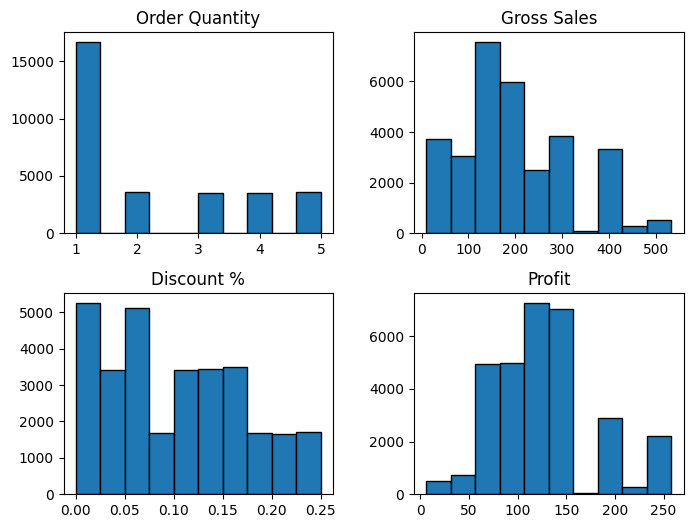

In [18]:
# Histograms for quantiative cols
fig, axis = plt.subplots(2, 2, figsize=(8, 6))
df_num.hist(ax=axis, edgecolor='black', grid=False)

In [19]:
# Avg order quantity, gross sales, profit, and discount % can also be calculated on a per order basis
print("Average number of units per order is", round(df_main.groupby(['Order ID'])['Order Quantity'].sum().mean(), 2))
print("Average gross sales per order is", round(df_main.groupby(['Order ID'])['Gross Sales'].sum().mean(), 2))
print("Average profit per order is", round(df_main.groupby(['Order ID'])['Profit'].sum().mean(), 2))

# Average discount % per order must be calculated slightly differently
# Create new col for price paid
df_main['Price Paid']=(1-df_main['Discount %'])*df_main['Gross Sales']
total_price_paid=df_main.groupby(['Order ID'])['Price Paid'].sum().sum()
total_gross_sales=df_main.groupby(['Order ID'])['Gross Sales'].sum().sum()
avg_discount_dec=1-(total_price_paid/total_gross_sales)
print("Average discount percentage (in decimal format) is", round(avg_discount_dec, 3))

Average number of units per order is 5.99
Average gross sales per order is 558.3
Average profit per order is 360.75
Average discount percentage (in decimal format) is 0.101


In [20]:
# Finally, let's examine frequencies for key qualitative columns
df_qual=df_main[['Product Department', 'Product Category', 'Customer Market', 'Customer Region', 'Warehouse Country', 'Shipment Mode']]

# Before creating plots, let's make some replacements in the product category column
# There's a big drop off after the top 9 categories, so let's replacement everything after that with "Other"
top_9=["Cleats", "Men's Footwear", "Women's Apparel", "Indoor/Outdoor Games", "Fishing", "Water Sports", "Camping & Hiking", "Cardio Equipment", "Shop By Sport"]
df_qual["Product Category"]=df_qual["Product Category"].apply(lambda x: x if x in top_9 else "Other")
df_qual["Product Category"].value_counts()

Cleats                  4298
Men's Footwear          3855
Women's Apparel         3622
Other                   3573
Indoor/Outdoor Games    3416
Fishing                 2878
Water Sports            2688
Camping & Hiking        2427
Cardio Equipment        2190
Shop By Sport           1924
Name: Product Category, dtype: int64

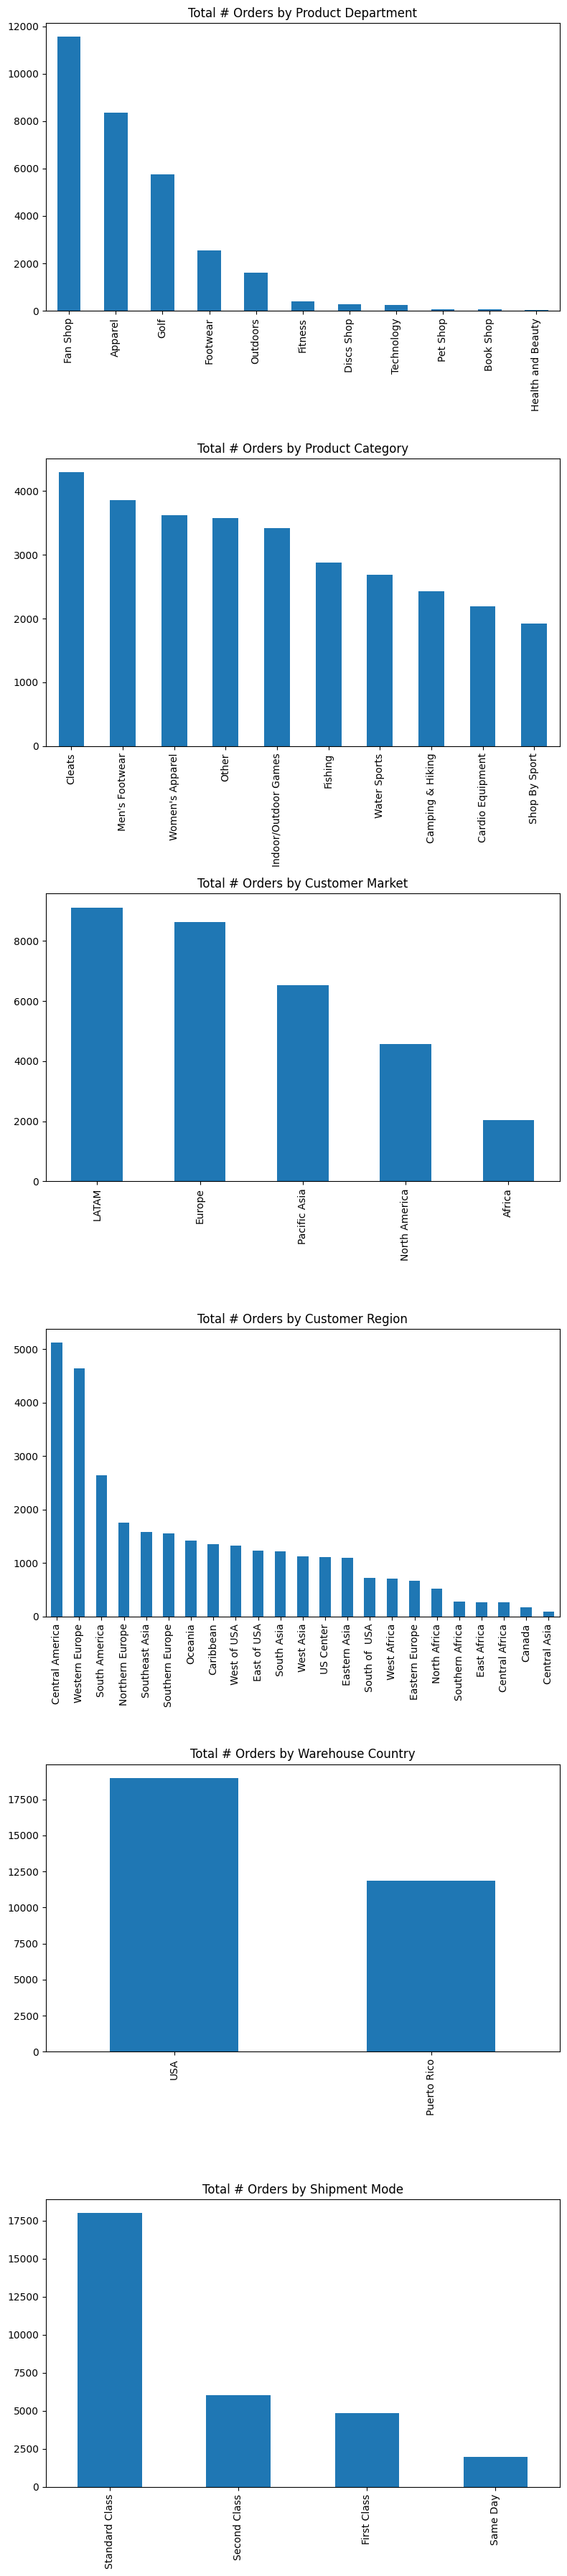

In [21]:
# Create subplots
fig, axs = plt.subplots(len(df_qual.columns), 1, figsize=(8, 6 * len(df_qual.columns)))

# Iterate over columns
for i, col in enumerate(df_qual.columns):
    # Plot value counts as bar plot
    df_qual[col].value_counts().plot.bar(ax=axs[i], title='Total # Orders by ' + col)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [22]:
# Inspect inventory, fulfillment files
df_inv=pd.read_csv("data/inventory.csv")
df_inv.head()

,Product Name,Year Month,Warehouse Inventory,Inventory Cost Per Unit
0,Perfect Fitness Perfect Rip Deck,201712,0,0.69517
1,Nike Men's Dri-FIT Victory Golf Polo,201712,2,1.29291
2,O'Brien Men's Neoprene Life Vest,201712,0,0.56531
3,Nike Men's Free 5.0+ Running Shoe,201712,1,1.26321
4,Under Armour Girls' Toddler Spine Surge Runni,201712,0,1.47648


In [23]:
# Examine shape, columns of df_inv
print(df_inv.shape, df_inv.columns)

(4200, 4) Index(['Product Name', ' Year Month ', ' Warehouse Inventory ',
       'Inventory Cost Per Unit'],
      dtype='object')


In [24]:
# Rename columns to remove whitespace
df_inv=df_inv.rename(columns=lambda x: x.strip())

In [25]:
# Let's examine average inventory by month by product department

# Drop duplicates in df_main
df_temp=df_main.drop_duplicates(subset=['Product Name'], keep='first')

# Join df_inv onto df_main
df_inv=df_inv.merge(df_temp[['Product Department', 'Product Name']], on='Product Name', how='left')
df_inv=df_inv[['Product Department', 'Product Name', 'Year Month', 'Warehouse Inventory', 'Inventory Cost Per Unit']]

# Create new datetime column
df_inv['YearMonthNew']=pd.to_datetime(df_inv['Year Month'], format='%Y%m')
df_inv

,Product Department,Product Name,Year Month,Warehouse Inventory,Inventory Cost Per Unit,YearMonthNew
0,Apparel,Perfect Fitness Perfect Rip Deck,201712,0,0.69517,2017-12-01
1,Golf,Nike Men's Dri-FIT Victory Golf Polo,201712,2,1.29291,2017-12-01
2,Fan Shop,O'Brien Men's Neoprene Life Vest,201712,0,0.56531,2017-12-01
3,Footwear,Nike Men's Free 5.0+ Running Shoe,201712,1,1.26321,2017-12-01
4,Golf,Under Armour Girls' Toddler Spine Surge Runni,201712,0,1.47648,2017-12-01
...,...,...,...,...,...,...
4195,Outdoors,TaylorMade 2017 Purelite Stand Bag,201501,0,1.44662,2015-01-01
4196,Outdoors,Ogio Race Golf Shoes,201501,0,0.10310,2015-01-01
4197,Outdoors,GolfBuddy VT3 GPS Watch,201501,0,1.77747,2015-01-01
4198,Outdoors,Titleist Small Wheeled Travel Cover,201501,0,0.15244,2015-01-01


In [26]:
# Use groupby to get sum of inventory units by department, year month
df_ts=df_inv.groupby(['Product Department', 'YearMonthNew'])['Warehouse Inventory'].sum().reset_index()
df_ts.head()

,Product Department,YearMonthNew,Warehouse Inventory
0,Apparel,2015-01-01,260
1,Apparel,2015-02-01,783
2,Apparel,2015-03-01,711
3,Apparel,2015-04-01,731
4,Apparel,2015-05-01,785


In [27]:
# Create list of distinct Prod Dep values
prod_list=df_ts['Product Department'].unique()

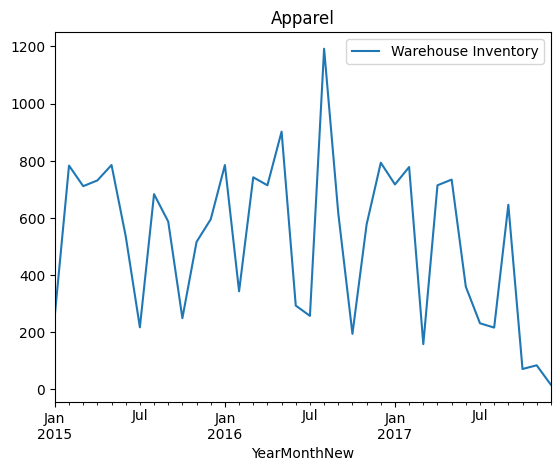

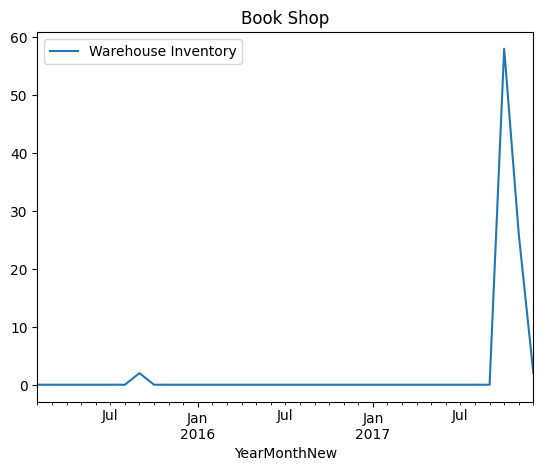

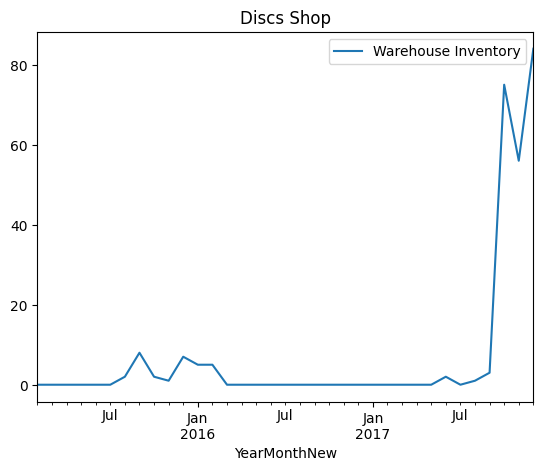

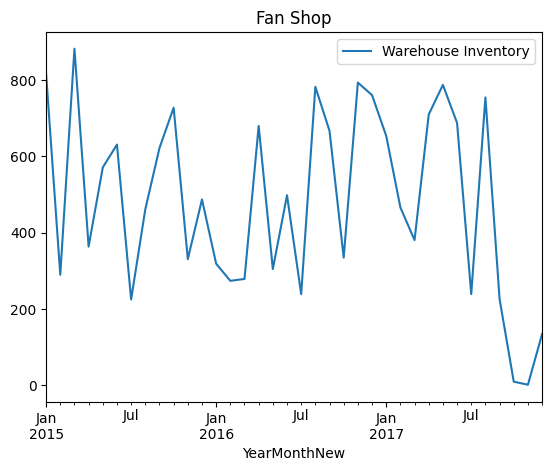

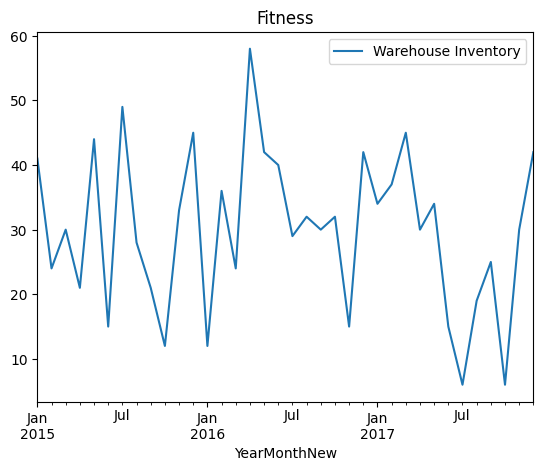

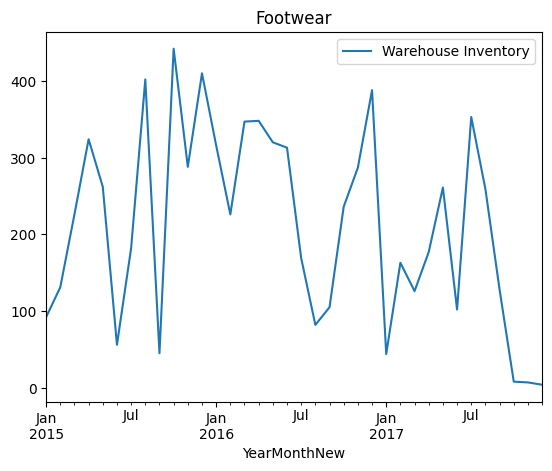

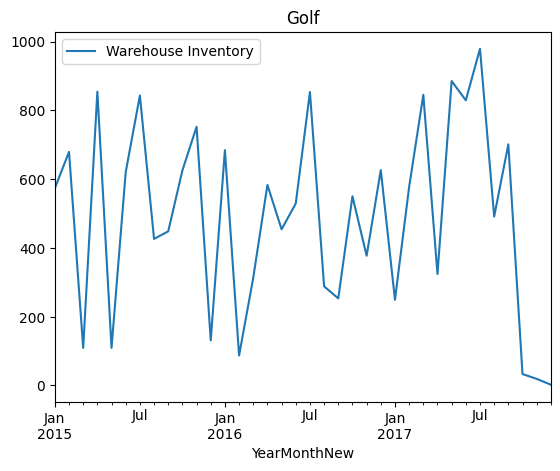

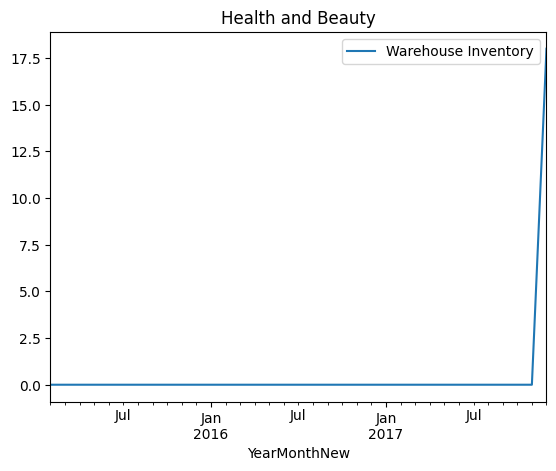

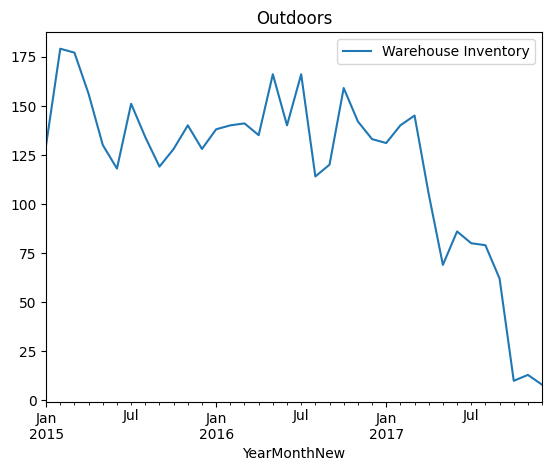

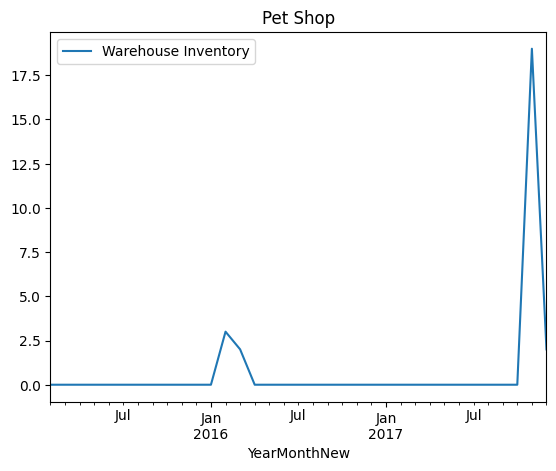

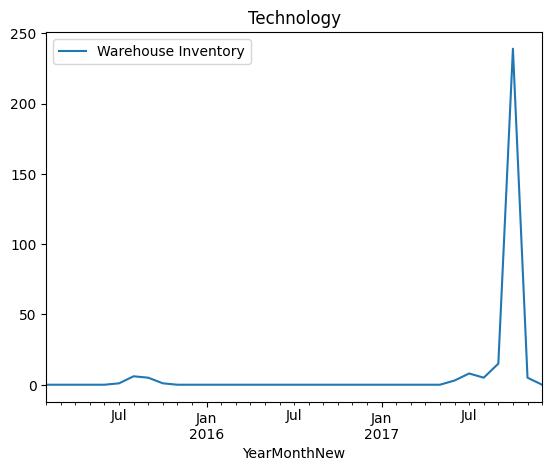

In [28]:
# Subplots test
for i in range(0, len(prod_list)):
    df_ts[df_ts['Product Department']==prod_list[i]].plot(x='YearMonthNew', y='Warehouse Inventory', title=prod_list[i])  
plt.show()

In [29]:
# Inspect first few rows of fulfillment
df_ful=pd.read_csv("data/fulfillment.csv")
df_ful.head()

,Product Name,Warehouse Order Fulfillment (days)
0,Perfect Fitness Perfect Rip Deck,8.3
1,Nike Men's Dri-FIT Victory Golf Polo,6.6
2,O'Brien Men's Neoprene Life Vest,5.5
3,Nike Men's Free 5.0+ Running Shoe,9.4
4,Under Armour Girls' Toddler Spine Surge Runni,6.3


In [30]:
# Examine shape of df_ful
df_ful.shape

(118, 2)

In [31]:
# Join fulfillment df onto df_main
df_ful=df_ful.merge(df_main[['Product Department', 'Product Category', 'Product Name']], on='Product Name', how='left')
df_ful=df_ful.drop_duplicates(keep='first')

# Some columns have a leading/trailing spaces in their names, let's remove those
df_ful=df_ful.rename(columns=lambda x: x.strip())
df_ful=df_ful[['Product Department', 'Product Category', 'Product Name', 'Warehouse Order Fulfillment (days)']]
df_ful.head()

,Product Department,Product Category,Product Name,Warehouse Order Fulfillment (days)
0,Apparel,Cleats,Perfect Fitness Perfect Rip Deck,8.3
4292,Golf,Women's Apparel,Nike Men's Dri-FIT Victory Golf Polo,6.6
7914,Fan Shop,Indoor/Outdoor Games,O'Brien Men's Neoprene Life Vest,5.5
11330,Footwear,Cardio Equipment,Nike Men's Free 5.0+ Running Shoe,9.4
13456,Golf,Shop By Sport,Under Armour Girls' Toddler Spine Surge Runni,6.3


In [32]:
# Let's compare avg fulfillment time by product department
dep_series=df_ful.groupby(['Product Department'])['Warehouse Order Fulfillment (days)'].mean()
dep_df=dep_series.reset_index()
dep_df=dep_df.rename(columns={0:'Product Department', 1:'Avg Fulfillment Time'})
dep_df['Warehouse Order Fulfillment (days)']=round(dep_df['Warehouse Order Fulfillment (days)'], 2)
dep_df.head()

,Product Department,Warehouse Order Fulfillment (days)
0,Apparel,5.96
1,Book Shop,5.20
2,Discs Shop,7.05
3,Fan Shop,3.96
4,Fitness,5.95


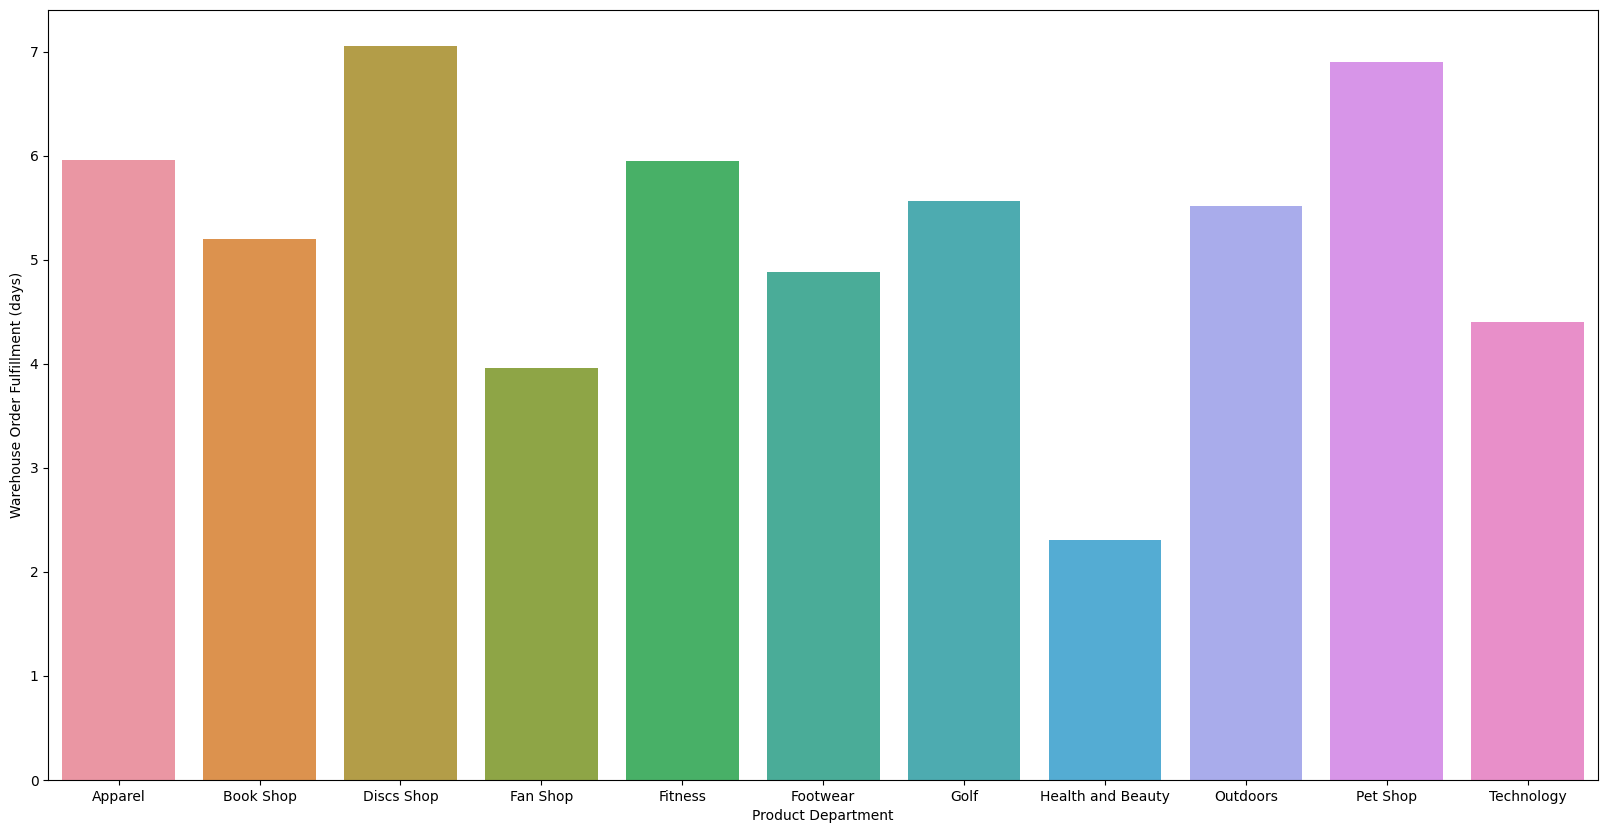

In [33]:
# Plot fulfillment times in bar chart
plt.figure(figsize=(20, 10))
plt.xticks(fontsize=10)
sns.barplot(data=dep_df, x="Product Department", y="Warehouse Order Fulfillment (days)")
plt.show()

In [34]:
# Can also compare fulfillment more granularly by considering prod category
dep_series2=df_ful.groupby(['Product Department', 'Product Category'])['Warehouse Order Fulfillment (days)'].mean()
dep_df2=dep_series2.reset_index()
dep_df2=dep_df2.rename(columns={0:'Product Department', 1:'Product Category', 2:'Avg Fulfillment Time'})
dep_df2['Warehouse Order Fulfillment (days)']=round(dep_df2['Warehouse Order Fulfillment (days)'], 2)
dep_df2.head()

,Product Department,Product Category,Warehouse Order Fulfillment (days)
0,Apparel,Baby,7.9
1,Apparel,Children's Clothing,2.7
2,Apparel,Cleats,4.8
3,Apparel,Crafts,7.1
4,Apparel,Men's Clothing,6.5


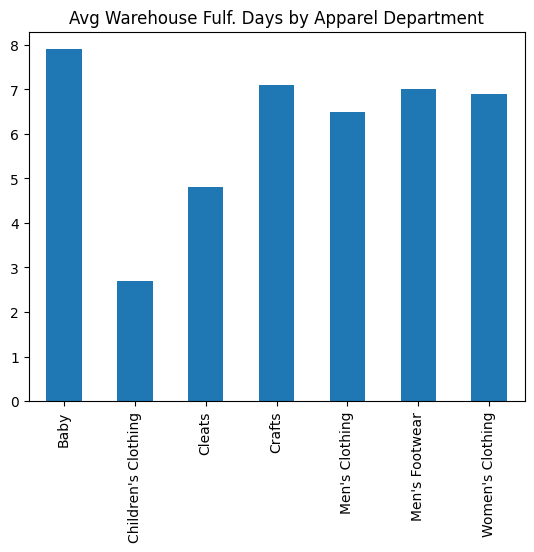

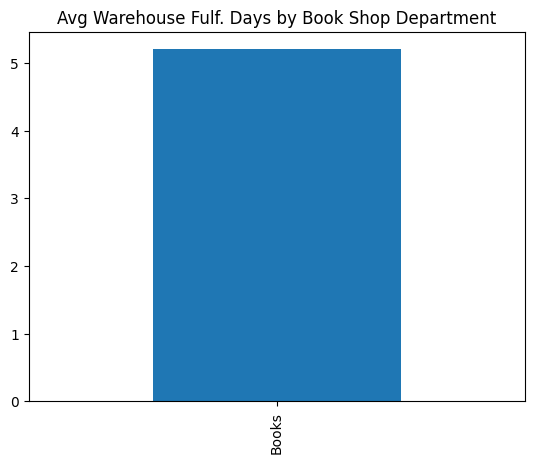

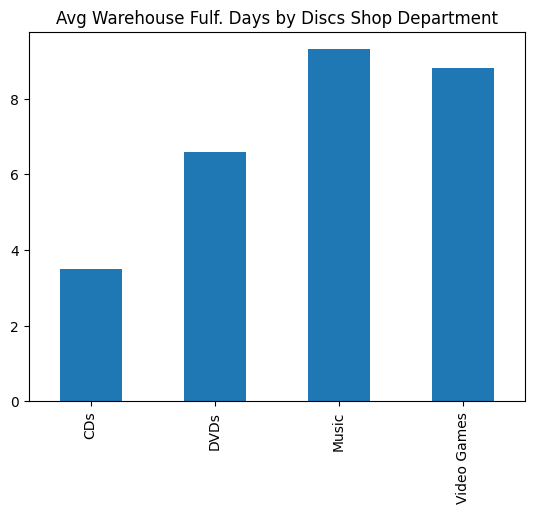

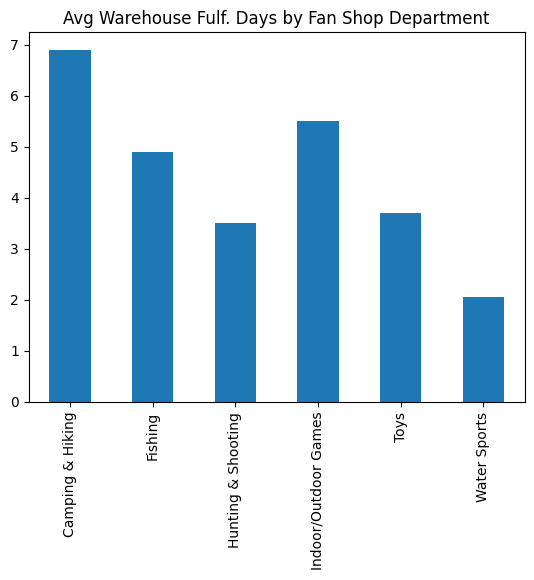

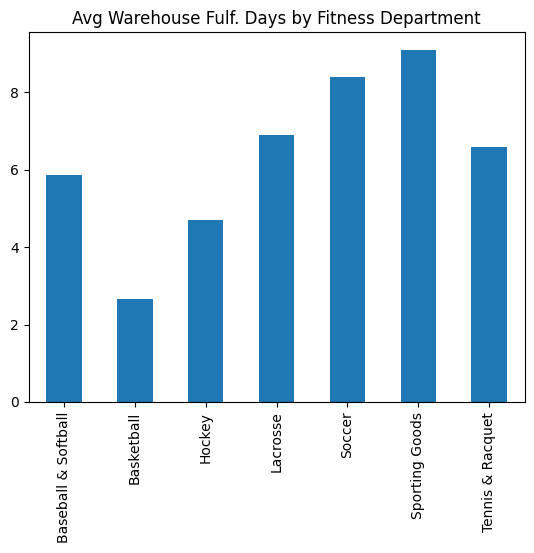

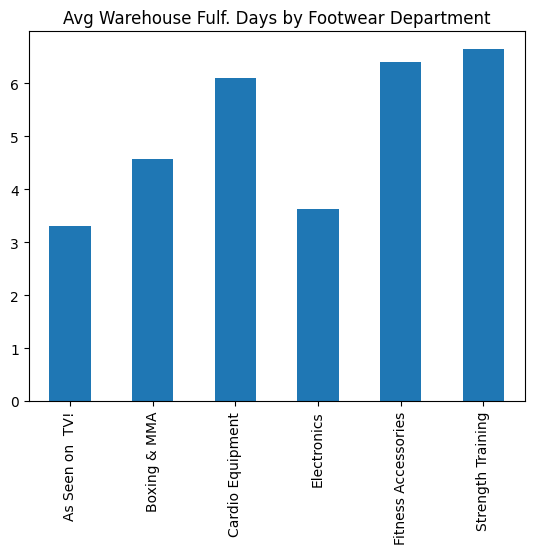

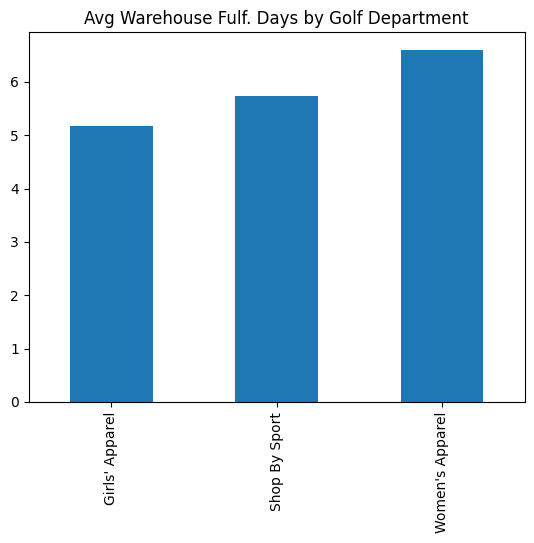

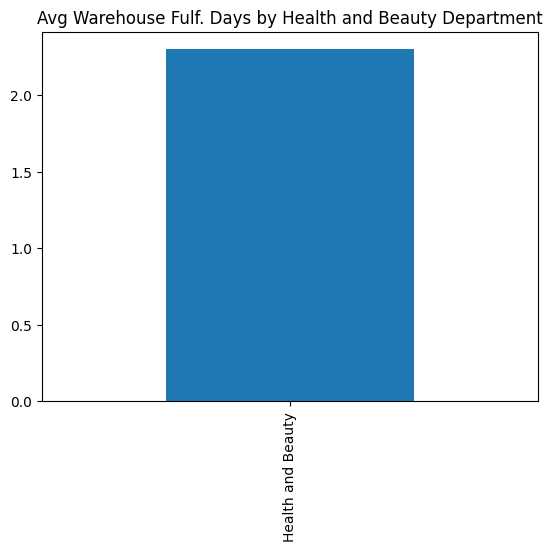

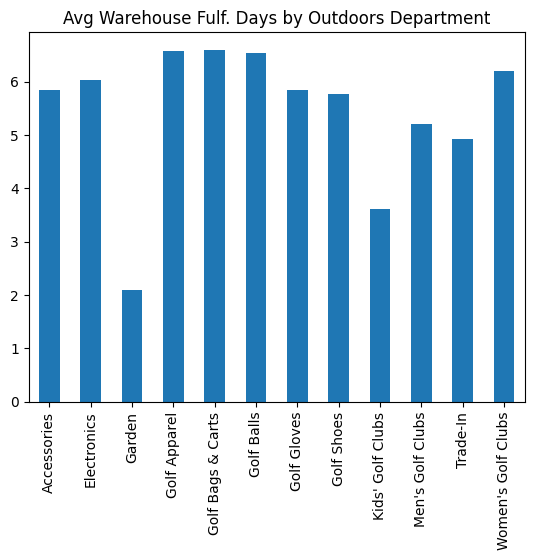

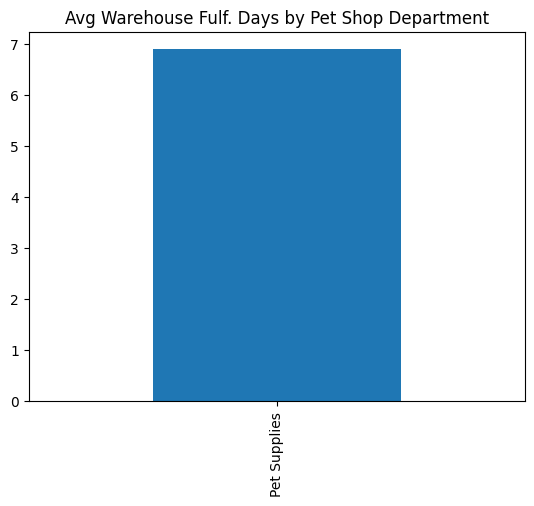

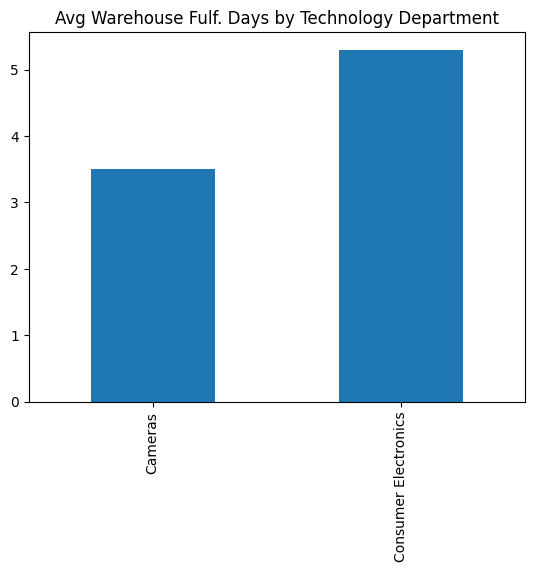

In [35]:
# Create unique list of product category elements
prod_list2=dep_df2['Product Department'].unique()

# Use for loop to iterate over different product categories
for i in range(0, len(prod_list2)):
    dep_df2[dep_df2['Product Department']==prod_list2[i]].plot.bar(x='Product Category', y="Warehouse Order Fulfillment (days)", title="Avg Warehouse Fulf. Days by "+prod_list2[i] + " Department", legend=False, xlabel='')  

# Show plots
plt.show()

In [36]:
# Write all three files to folder
df_main.to_csv("OrdersAndShipments.csv", index=False)
df_inv.to_csv("InventoryFinal.csv", index=False)
df_ful.to_csv("FulfillmentFinal.csv", index=False)